In [1]:
import re
import os
import sys
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, FuncNorm
import matplotlib.transforms as mtransforms
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FixedLocator, NullLocator, FixedFormatter

if '..' not in sys.path:
    sys.path.append('..')
from dlml.data import load_data_areas

fontsize = 8
lw = 0.75

# matplotlib.rc('font', **{'family': 'Times New Roman', 'size': fontsize})
matplotlib.rc('font', **{'size': fontsize})
matplotlib.rc('axes', **{'linewidth': 0.75, 'labelsize': fontsize})
matplotlib.rc('xtick', **{'labelsize': fontsize})
matplotlib.rc('ytick', **{'labelsize': fontsize})
matplotlib.rc('xtick.major', **{'width': lw, 'size':3})
matplotlib.rc('ytick.major', **{'width': lw, 'size':3})
matplotlib.rc('ytick.minor', **{'width': lw, 'size':1.5})

%matplotlib inline

In [2]:
def list_data_files(data_dir, set_name, grid_sorted=True, verbose=False):
    momentum = lambda H, S, fn=60: 2 * H@S / fn * 1e-3
    S = np.array([700., 800., 100.])
    files = sorted(glob.glob(os.path.join(data_dir, f'*_{set_name}_set.h5')))
    n_files = len(files)
    N = int(np.sqrt(n_files))
    files = [[files[i*N + j] for j in range(N)] for i in range(N)]
    i,j = 0,0
    sorted_files = []
    while len(sorted_files) < n_files:
        try:
            sorted_files.append(files[i][j])
            if verbose:
                H = list(map(float, re.findall('\d.\d+', os.path.basename(sorted_files[-1]))))
                H_G2 = H[1]
                H_G3 = H[2]
                H_Comp11 = H[-3]
                print('({},{}): {:.4f}'.format(i, j, momentum(np.array([H_G2, H_G3, H_Comp11]), S)))
        except:
            pass
        if i == 0:
            i,j = j+1, 0
        else:
            i,j = i-1, j+1
    return sorted_files

In [3]:
data_dirs = [
    '../data/IEEE39/converted_from_PowerFactory/all_stoch_loads/var_H_area_1_comp_grid/coarse_H_comp11_0.1',
    '../data/IEEE39/converted_from_PowerFactory/all_stoch_loads/var_H_area_1_comp_grid/coarse_H_comp11_2.5',
    '../data/IEEE39/converted_from_PowerFactory/all_stoch_loads/var_H_area_1_comp_grid/coarse_H_comp11_5.0'
]
set_name = 'training'
data_files = [f for data_dir in data_dirs for f in list_data_files(data_dir, set_name)]
n_data_files = len(data_files)
print(f'Found {n_data_files} data files.')

Found 108 data files.


In [4]:
buses = 3, 14, 17, 39
var_names = [f'Vd_bus{bus}' for bus in buses]
generators_areas_map = [
    ["G02", "G03", "Comp11"],
    ["G04", "G05", "G06", "G07", "Comp21"],
    ["G08", "G09", "G10", "Comp31"],
    ["G01"]
]
generators_Pnom = {
    "G01": 10000e6, "G02": 700e6, "G03": 800e6, "G04":  800e6, "G05":  300e6,
    "G06":   800e6, "G07": 700e6, "G08": 700e6, "G09": 1000e6, "G10": 1000e6,
    "Comp11": 100e6, "Comp21": 100e6, "Comp31": 100e6
}
area_measure = 'momentum'

In [5]:
max_block_size = 100
cutoff = 0.1
force = True
filename = f'spectra_compensators_buses={"-".join(map(str,buses))}_cutoff={cutoff:.02f}_blocks={max_block_size}'
if not os.path.isfile(filename + '.npz') or force:
    ret_fft = load_data_areas({set_name: data_files},
                              var_names,
                              generators_areas_map[:1],
                              generators_Pnom,
                              area_measure,
                              trial_dur=60,
                              max_block_size=max_block_size,
                              use_tf=False, add_omega_ref=True,
                              use_fft=True,
                              Wn=cutoff, filter_order=8, btype='hp')
    F = ret_fft[0]
    Xf = ret_fft[1][set_name]
    y = np.squeeze(ret_fft[2][set_name])
    block_size = Xf[0].shape[0] // n_data_files
    print(f'Block size: {block_size}.')
    Xfm = np.array([[Xf[var_idx, j*block_size : (j+1)*block_size, :].mean(axis=0)
                     for j in range(n_data_files)] for var_idx in range(len(buses))])
    ym = y[::block_size]
    np.savez_compressed(filename + '.npz', max_block_size=max_block_size, block_size=block_size,
                        F=F, Xfm=Xfm, ym=ym, cutoff=cutoff, buses=buses, var_names=var_names,
                        data_files=data_files, n_data_files=n_data_files, data_dirs=data_dirs,
                        set_name=set_name)
else:
    data = np.load(filename + '.npz')
    for key in data.files:
        globals()[key] = data[key]

100%|██████████████████████████████████████████████████████████████████████████████████████| 108/108 [01:27<00:00,  1.24it/s]


Block size: 500.


In [6]:
min_fft = Xfm.min(axis=(1,2))
max_fft = Xfm.max(axis=(1,2))

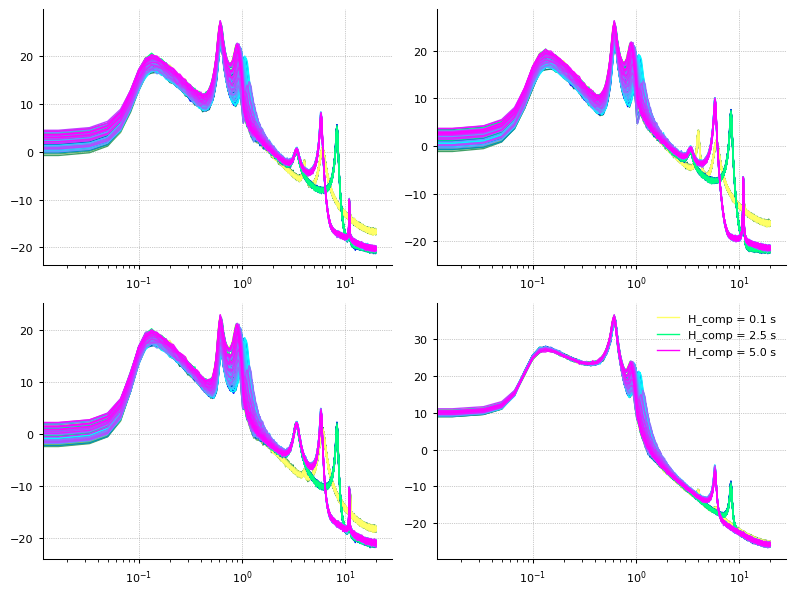

In [7]:
H_comp = [0.1, 2.5, 5.0]
cmap_names = 'summer', 'winter', 'cool'
cmaps = [plt.get_cmap(name, n_data_files//3) for name in cmap_names]
rows,cols = 2,2
w,h = 4,3
fig,ax = plt.subplots(rows, cols, figsize=(cols*w, rows*h))
for k,bus in enumerate(buses):
    i,j = k//cols, k%cols
    for n,cmap in enumerate(cmaps):
        for m in range(n_data_files//3):
            if m == n_data_files // 3 - 1:
                lbl = 'H_comp = {:.1f} s'.format(H_comp[n])
            else:
                lbl = None
            ax[i][j].semilogx(F, 20*np.log10(Xfm[k, n*n_data_files//3+m, :]),
                              lw=1, color=cmap(m), label=lbl)
    for side in 'right','top':
        ax[i][j].spines[side].set_visible(False)
    ax[i][j].grid(which='major', axis='both', lw=0.5, ls=':', color=[.6,.6,.6])
ax[i][j].legend(loc='upper right', frameon=False)
fig.tight_layout()

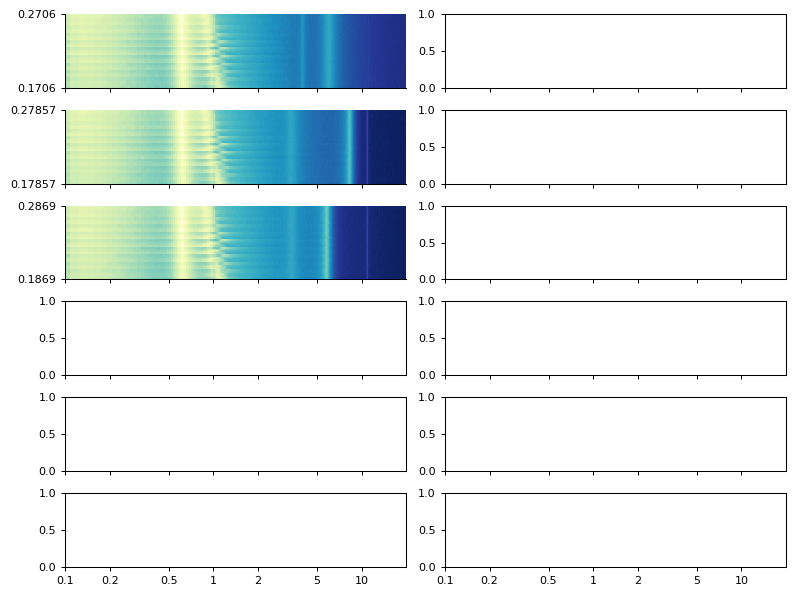

In [8]:
_forward = lambda x: 20 * np.log10(x)
_inverse = lambda y: 10 ** (y/20)
H_comp = [0.1, 2.5, 5.0]
ticks = np.array([0.1, 0.2, 0.5, 1, 2, 5, 10, 20])
cmap = plt.cm.YlGnBu_r
n_H = len(H_comp)
rows,cols = 2,2
w,h = 4,1
fig,ax = plt.subplots(rows*n_H, cols, figsize=(cols*w, rows*h*n_H), sharex=True)
for r in range(rows):
    for j in range(cols):
        for k in range(n_H):
            i = r*n_H + k
#             norm = LogNorm(vmin=min_fft[r*cols+j], vmax=max_fft[r*cols+j])
            norm = FuncNorm((_forward, _inverse), vmin=min_fft[r*cols+j], vmax=max_fft[r*cols+j])
            X,Y = np.meshgrid(F, ym[k*n_data_files//n_H : (k+1)*n_data_files//n_H])
#             if i == 0 and j == 0:
            ax[i][j].pcolor(X, Y, Xfm[r*cols+j, k*n_data_files//n_H:(k+1)*n_data_files//n_H,:],
                            cmap=cmap, norm=norm)
            ax[i][j].set_xscale('log')
            ax[i][j].set_xlim(ticks[[0,-1]] + np.array([0,1]))
            ax[i][j].xaxis.set_major_locator(FixedLocator(ticks))
            ax[i][j].xaxis.set_minor_locator(NullLocator())
            ax[i][j].xaxis.set_major_formatter(FixedFormatter([f'{tick:g}' for tick in ticks]))
            ax[i][j].set_ylim([Y.min(), Y.max()])
            ax[i][j].set_yticks([Y.min(), Y.max()])
#             ax[i][j].set_xticklabels([])
#             ax[i][j].set_yticklabels([])
            for side in 'right','top':
                ax[i][j].spines[side].set_visible(False)
        break
    break
ax[0][0].set_xlim([cutoff, F[-1]])
fig.tight_layout()